# Technincal Report

### Intro

Dota 2 is a Multiplayer Online Battle Area (MOBA) in which teams battle to destroy each other’s fountain. Each team player will choose a unique hero who has a 4 unique abilities. Hero types fall into different types of roles i.e. carry (main damage dealer) or support (aids heroes by healing, providing crowd control, escape or attack). Dota 2, and Esports in general, is a fast and up and coming enterprise in the sporting industry. Prize pool for tournaments can be upwards of  $20,000,000 (Dota2 Website) USD providing fierce competition between teams from all over the world.

It is estimated that 134 million people watch Esports, (Forbes Website).  People watch Esports through livestreaming platforms such as Twitch and YouTube. Live events can be viewed using DreamHack and Intel Extreme Masters. The growth and popularity of Esports is fast becoming a prime industry for economic opportunity. 

The market of Esports has also spurred a market for Esports betting. Sites such as bet365.com and sports.betway.com offer individuals the opportunity to place bets on games. This prompted an interest as a Data scientist to explore and create profitable trading strategies. The strategies would be based on a model which would calculate the odds of each team winning and then hedge each bet based on the model’s prediction.


### Data

The most challenging part of this endeavour was the data extraction. Since no api was available to download, data scraping was performed.  This was a challenging process as three different sites were used for data scraping and there were conflicts in the different methods used by each site as it relates to names of teams and players. 

To resolve this conflict just one site was ultimately used. That site was Dotabuff.com. The testing was both time consuming and tedious. Formats would change, data would be available for some matches and not others, and getting banned rate was limited.  The results yielded 123456 rows and 5 features. Because of the amount of variation and amount of times players changed teams, results were limited to  2015*.

 Multiple variables were used and data had a moving average of win rate (1 month, 3 months, 6 months, year, and all time) as well as average duration vs the opponent for the past (1,3,5,10 games) as well as the average duration of the teams past games (1,3,5 games). A proxy for teams’ skills was identified.  The most logical conclusion was to use games won as this proxy. Included were total matches won as well as a log of matches won. By using the log of matches won means there are diminishing returns to scale as the number of matches increases. Said another way, an increase from 20-100 games won will have more of an effect on the probability of winning than an increase from 820-900. Year month league were also used. It was suspected that no effects would be found within the data but it was added to see if it would be possible to find any possible correlation.


In [73]:
###Import Libraries
import pickle
import requests
import pandas as pd
import numpy as np
from scrapy.selector import Selector
from scrapy.http import HtmlResponse
from bs4 import BeautifulSoup
from datetime import datetime
import matplotlib.pyplot as plt
import time
from datetime import datetime
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
import seaborn as sns
import patsy
import itertools
import glob

from scipy import linalg
from sklearn.metrics import roc_curve, auc

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn.linear_model import LogisticRegression, LinearRegression
import statsmodels.api as sm
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

from IPython.display import Image




%matplotlib inline




# Scraping
#### Since none of the data was available through api's i relied soley on scrapping my entire data set. This was time consuming, lengthy and messy. It took just over a week to scrape this entire data set due to rate limiting from the host server. 

In [14]:
### This frame loops through every team on the page and finds all the team names and their links to there homepage
url = 'https://www.dotabuff.com/esports/teams'
user_agent = {'User-agent': 'Mozilla/5.0'}
response = requests.get(url, headers=user_agent )
HTML=response.text
team_links = []

### Looping through the table to find team name and the team url
for row in Selector(text=HTML).xpath('//*[@id="teams-all"]/table/tbody/tr'):
    tag= row.xpath('./td/a[@class="esports-link"]/@href').extract()[0]
    link = "https://www.dotabuff.com" + tag
    team_links.append({
            'link': link,
            'team': row.xpath('./td/a/img/@title').extract()[0]
        })

In [15]:
###Create a Data frame from the scraped data
team_page = pd.DataFrame(team_links)
###Rename column and append the approriate prefix for each link 
team_page['match_page']= team_page.link.map(lambda x: x +'/matches')
##Show head of DataFrame
team_page.head()

,link,team,match_page
0,https://www.dotabuff.com/esports/teams/39,Evil Geniuses,https://www.dotabuff.com/esports/teams/39/matches
1,https://www.dotabuff.com/esports/teams/2586976,OG Dota2,https://www.dotabuff.com/esports/teams/2586976...
2,https://www.dotabuff.com/esports/teams/36,Natus Vincere,https://www.dotabuff.com/esports/teams/36/matches
3,https://www.dotabuff.com/esports/teams/2163,Team Liquid,https://www.dotabuff.com/esports/teams/2163/ma...
4,https://www.dotabuff.com/esports/teams/3214108,Team NP,https://www.dotabuff.com/esports/teams/3214108...


In [ ]:
### Function to find all the links for each game played by each team.
###Takes in the teams url, and team name
def parse_url(team_url, team_name):

###Goes to the first page of all the matches played by the team
    url = team_url
    user_agent = {'User-agent': 'Mozilla/5.0'}
    response = requests.get(url, headers=user_agent )
    HTML=response.text

### Looping through each row of the table and pulling out, match date, league, duration, opponent url(explain later)
### match result(win or loss) and the match id(unique identifier for each game)
    for row in Selector(text=HTML).xpath('/html/body/div[1]/div[7]/div[3]/section[2]/article/table/tbody/tr'):
###Create a dictionary which can then be turned into a Dataframe    
        team_match_history.append({
                'team':team_name,
                'match_date':row.xpath("./td[2]/span/time/@datetime").extract()[0],
                'league':row.xpath('./td/a/img/@title').extract()[0],
                'duration':row.xpath('./td[4]/text()').extract()[0], 
                'opponent_url':row.xpath('./td[6]/a[1]/img/@data-tooltip-url').extract(),
                'match_result':row.xpath('./td[2]/div/a/text()').extract()[0],
                'match_id': row.xpath('./td[2]/div/a/@href').extract()[0],
            
        })
### This try statement asks 'is there another page of matches to get results from?'     
    try:
        more_link = Selector(text=HTML).xpath('/html/body/div[1]/div[7]/div[3]/section[2]/article/nav/span/a[@rel="next"]/@href').extract()[0]

        if len(more_link) > 0:
### len function checks to see if there is indeeed another page if there is go to the next page
            more_url = 'https://www.dotabuff.com' + more_link
### Sleep timer to avoid getting request rate limited    
            time.sleep(0.1)
###Go to the new page and run the function all over again(recurrsive)
            return parse_url(more_url, team_name)

###If there is a problem with the link the except statement will report out 'problem' so it can be investigated later
    except:
        print 'problem'
        print response.url
#       
        pass
        

In [ ]:
### This was referenced earlier, got all the links for each opponent so we could 
### go to the team page for each and pull out the name of the opponent
url_list = team_match_history.opp_url.unique()
team_dictionary ={}

### Go to each opponent url
for i in url_list:
    
### Sleep timer
    time.sleep(5)
    url = i
    user_agent = {'User-agent': 'Mozilla/5.0'}
    response = requests.get(url, headers=user_agent )
    HTML=response.text

### If you can find a name for the opponent append it to the dictionary
    try:
        team_name = Selector(text=HTML).xpath('/html/body/div[1]/div[7]/div[2]/div[1]/div[1]/div[2]/h1/text()').extract()[0]
        print team_name
        team_dictionary[i] =team_name
### If it cant find the name of the opponent, label them as 'NaN'
    except:
        team_dictionary[i] ='NaN'

    

In [ ]:
### Function to clean the opponent url column
def opponent_cleaner(x):
    x = str(x)
    x=x.replace("'",'')
    x=x.replace("u",'')
    x =x.replace('[','')
    x =x.replace(']','')
    x = x.replace('/tooltip','')
    x = 'https://www.dotabuff.com' + x
    return x
team_match_history['opp_url']= team_match_history.opponent_url.apply(opponent_cleaner)

In [ ]:
### Create a list of all the opponents urls
url_list = team_match_history.opp_url.unique()
### Create a blank dictionary
team_dictionary ={}

### Loop through each of the opponent urls and extract the team
for i in url_list:
    time.sleep(5)
    url = i
    user_agent = {'User-agent': 'Mozilla/5.0'}
    response = requests.get(url, headers=user_agent )
    HTML=response.text
### Use try function to incase of error
    try:
### If it can find the team name append the dictionary
        team_name = Selector(text=HTML).xpath('/html/body/div[1]/div[7]/div[2]/div[1]/div[1]/div[2]/h1/text()').extract()[0]
        print team_name
        team_dictionary[i] =team_name
    except:
### If cant find the team name label as 'NaN'
        team_dictionary[i] ='NaN'

    

In [ ]:
### Clean and apply both functions
team_match_history['opp_url'] = df_1.opponent_url.apply(opponent_cleaner)
team_match_history['opponent'] = df_1.opp_url.apply(find_team)
### Data all had to be appended together since scraping was over 7days i appended all the dataframes into one large dataframe

# Cleaning

In [25]:
### Raw view of the data before it was cleaned
matches.head()

,duration,league,match_date,match_id,match_result,opponent_url,team,opp_url,opponent
0,50:55,Dota Pit League Season Five,2017-01-23T02:30:19+00:00,/matches/2933092997,Won Match,[/esports/teams/2586976/tooltip],Evil Geniuses,https://www.dotabuff.com/esports/teams/2586976,OG Dota2
1,38:12,Dota Pit League Season Five,2017-01-22T22:23:41+00:00,/matches/2932903146,Won Match,[/esports/teams/2586976/tooltip],Evil Geniuses,https://www.dotabuff.com/esports/teams/2586976,OG Dota2
2,56:11,Dota Pit League Season Five,2017-01-22T22:29:22+00:00,/matches/2932890423,Won Match,[/esports/teams/2586976/tooltip],Evil Geniuses,https://www.dotabuff.com/esports/teams/2586976,OG Dota2
3,53:55,Dota Pit League Season Five,2017-01-22T22:19:25+00:00,/matches/2932882162,Lost Match,[/esports/teams/2586976/tooltip],Evil Geniuses,https://www.dotabuff.com/esports/teams/2586976,OG Dota2
4,52:59,Dota Pit League Season Five,2017-01-22T20:19:14+00:00,/matches/2932729903,Won Match,[/esports/teams/2586976/tooltip],Evil Geniuses,https://www.dotabuff.com/esports/teams/2586976,OG Dota2


In [29]:
### Defining all out functions to clean all the data
def duration_cleaner(x):
    x = str(x)
    if len(x) <=5:
        mins = int(x[0:2])
        seconds =int(x[3:5])
        return mins
        
    
    else:
        hours = int(x[0])
        
        mins = int(x[2:4])+ hours*60
        seconds=int(x[6:8])
        return mins
    
def gpm_cleaner(x):
    x=str(x)
    try:
        return float(x)
    except:
        return 'NaN'
    
def win_rate_cleaner(x):
    x = str(x)
    try:
        x=x.replace("%","")
        return float(x)
    except:
        return 'Nan'
    
def date_cleaner(x):
    x = str(x)
    x = x[:10]
    x = datetime.strptime(x, '%Y-%m-%d')
    return x

def win_lose(x):
    x=str(x)
    if x=='Won Match':
        return 1
    else:
        return 0
def id_cleaner(x):
    x = str(x)
    try:
        x = x.replace('/matches/','')
        return int(x)
    except:
        return "NaN"

In [ ]:
###Applying functions to clean the data 

matches['won'] = matches.match_result.apply(win_lose)
matches.match_id = matches.match_id.apply(id_cleaner)
matches.duration = matches.duration.apply(duration_cleaner)
matches.match_date = matches.match_date.apply(date_cleaner)

In [33]:
#Selecting all dependant variables into new dataframe
matches = matches[['duration','league','match_date','team','opponent','match_id','won']]

In [37]:
###Finding the amount of matches for each opponent and placing them into a DataFrame

low_opponent_matches = pd.DataFrame(matches.opponent.value_counts())


#Taking newly created Dataframe and finding all opponents with less than 10 matches
low_match_opponents =[]
less_5_matches = low_opponent_matches[low_opponent_matches.opponent<10]
for i in less_5_matches.index:
    low_match_opponents.append(i)

###Finding the amount of matches for each team and placing them into a DataFrame
low_team = pd.DataFrame(matches.team.value_counts())

#Taking newly created Dataframe and finding all opponents with less than 10 matches
low_matches_team =[]
less_5_team = low_team[low_team.team<10]
for i in less_5_team.index:
    low_matches_team.append(i)
    

### Removing any teams or opponents which played less than 10 matches    
matches =matches[~matches.opponent.isin(low_match_opponents)]
matches = matches[~matches.team.isin(low_matches_team)]


In [38]:
###Dropping all nulls in the opponent column
matches = matches[~matches.opponent.isnull()]

In [39]:
### Creating 2 new columns, year and month of match date
matches['year'] = matches.match_date.map(lambda x: x.year)
matches['month'] = matches.match_date.map(lambda x: x.month)

In [48]:
### Finding all the teams labeled as 'team' and putting them into a list
team_list = []
for i in matches.team.unique():
    team_list.append(i)

### Feature Engineered Columns

In [49]:


##Function 1
#### Function to calculate the 1,3,6,12 and all matches played winrate based on the date of the current match

def win_rate_calculator(row):
    
###Generate a mask to find all the matches
    condition = (matches.team ==row.team ) & (matches.match_date < row.match_date )
    msk = pd.DataFrame(matches[condition][['match_date','won','opponent','duration','match_id']])
    
    one_month=row.match_date - relativedelta(months=+1)
    three_months = row.match_date - relativedelta(months=+3)
    six_months = row.match_date - relativedelta(months=+6)
    year = row.match_date - relativedelta(months=+12)
    all_time = row.match_date - relativedelta(months=+120)
    
    one_month_win_rate = msk[msk.match_date > one_month]['won'].mean()
    row['one_month_win_rate'] = one_month_win_rate

    
    
    three_month_win_rate = msk[msk.match_date > three_months]['won'].mean()
    row['three_month_win_rate'] = three_month_win_rate
    

    six_month_win_rate = msk[msk.match_date > six_months]['won'].mean()
    row['six_month_win_rate'] = six_month_win_rate
    

    year_win_rate = msk[msk.match_date > year]['won'].mean()
    row['year_win_rate'] = year_win_rate
    

    alltime_win_rate = msk[msk.match_date > all_time]['won'].mean()
    row['alltime_win_rate'] = alltime_win_rate
    
    return row


##Function 2
#### Function to calculate the 1,3,6,12 and all matches played winrate 
###based on the date of the current match for the opponent

def opponent_time_winrate(row):
### If the opponent is listed as a 'team' find all the match histories

###Generate a mask to find all the matches
    if row.opponent in team_list:
        oppponent = row.opponent
        condition = (matches.team ==row.opponent)& (matches.match_id < row.match_id)
        msk = pd.DataFrame(matches[condition][['match_date','won','opponent','duration','match_id','team']])

        one_month=row.match_date - relativedelta(months=+1)
        three_months = row.match_date - relativedelta(months=+3)
        six_months = row.match_date - relativedelta(months=+6)
        year = row.match_date - relativedelta(months=+12)
        all_time = row.match_date - relativedelta(months=+120)
        
        one_month_win_rate = msk[msk.match_date > one_month]['won'].mean()
        row['one_month_win_rate_opponent'] =one_month_win_rate
            
        three_month_win_rate = msk[msk.match_date > three_months]['won'].mean()
        row['three_month_win_rate_opponent'] = three_month_win_rate


        six_month_win_rate = msk[msk.match_date > six_months]['won'].mean()
        row['six_month_win_rate_opponent'] = six_month_win_rate


        year_win_rate = msk[msk.match_date > year]['won'].mean()
        row['year_win_rate_opponent'] = year_win_rate


        alltime_win_rate = msk[msk.match_date > all_time]['won'].mean()
        row['alltime_win_rate_opponent'] = alltime_win_rate

    else:
### If the opponent is listed as an 'opponent' find all the previous match histories 

###Generate a mask to find all the matches
        condition = (matches.opponent ==row.opponent)& (matches.match_id < row.match_id)
        msk = pd.DataFrame(matches[condition][['match_date','won','opponent','duration','match_id','team']])

### Finding all relevative time periods for the current match
        one_month=row.match_date - relativedelta(months=+1)
        three_months = row.match_date - relativedelta(months=+3)
        six_months = row.match_date - relativedelta(months=+6)
        year = row.match_date - relativedelta(months=+12)
        all_time = row.match_date - relativedelta(months=+120)
        
        
        one_month_win_rate = msk[msk.match_date > one_month]['won'].mean()
        row['one_month_win_rate_opponent'] =1.0-one_month_win_rate
            
        three_month_win_rate = msk[msk.match_date > three_months]['won'].mean()
        row['three_month_win_rate_opponent'] =1.0- three_month_win_rate


        six_month_win_rate = msk[msk.match_date > six_months]['won'].mean()
        row['six_month_win_rate_opponent'] =1.0- six_month_win_rate


        year_win_rate = msk[msk.match_date > year]['won'].mean()
        row['year_win_rate_opponent'] =1.0- year_win_rate


        alltime_win_rate = msk[msk.match_date > all_time]['won'].mean()
        row['alltime_win_rate_opponent'] =1.0- alltime_win_rate
        
    return row

##Function 3
### Function to calculate the mean of duration team between both teams for last 1,3,5 matches

def duration_vs_opponent(row):
    condition = (matches.team ==row.team) & (matches.match_id <= row.match_id )
    msk = pd.DataFrame(matches[condition][['match_date','won','opponent','duration','match_id']])
    

### Finding the last match/es played and taking the average duration for those games
    try:
        last_match = msk[msk.opponent == row.opponent ][['duration','match_id','won','match_date']].sort_values('match_date', ascending = False)['duration'][:1].mean()
        row['last_match_duration_opponent'] = last_match
    except:
        row['last_match_duration_opponent'] = 'NaN'
    try:
        three_match = msk[msk.opponent == row.opponent ][['duration','match_id','won','match_date']].sort_values('match_date', ascending = False)['duration'][:3].mean()
        row['three_match_duration_opponent'] = three_match
    except:
        row['three_match_duration_opponent'] = 'NaN'
    try:
        five_match = msk[msk.opponent == row.opponent ][['duration','match_id','won','match_date']].sort_values('match_date', ascending = False)['duration'][:5].mean()
        row['five_match_duration_opponent']=five_match
    except:
        row['five_match_duration_opponent']='NaN'
    try:
        ten_match = msk[msk.opponent == row.opponent ][['duration','match_id','won','match_date']].sort_values('match_date', ascending = False)['duration'][:10].mean()
        row['ten_match_duration_opponent']=ten_match
    except:
        row['ten_match_duration_opponent']='NaN'
        
    try:
        all_match = msk[msk.opponent == row.opponent ][['duration','match_id','won','match_date']].sort_values('match_date', ascending = False)['duration'].mean()
        row['all_match_duration_opponent']=all_match
    except:
        row['all_match_duration_opponent']='NaN'
        
    return row


##Function 4
def match_winrate_history(row):
    condition = (matches.team ==row.team) & (matches.match_id <= row.match_id)
    msk = pd.DataFrame(matches[condition][['match_date','won','opponent','duration','match_id','team']])

### Finding if they won the last match they played and taking the average winrate for those games
    try:
        last_match = msk['won'][1:2].mean()
        row['last_match_history'] = last_match
    except:
        row['last_match_history'] = 'NaN'
        
    try:
        three_match = msk['won'][1:4].mean()
        row['three_match_history'] = three_match
    except:
        row['three_match_history'] = 'NaN'

    try:
        five_match = msk['won'][1:6].mean()
        row['five_match_history'] = five_match
    except:
        row['five_match_history'] = 'NaN'

    return row

###Function 5

def match_winrate_history_opponent(row):

###If the team is labeled as a 'team' finding there last matches history by creating a mask and taking the mean
    if row.opponent in team_list:
        oppponent = row.opponent
        condition = (matches.team ==row.opponent)& (matches.match_id < row.match_id)
        msk = pd.DataFrame(matches[condition][['match_date','won','opponent','duration','match_id','team']])
        
        try:
            last_match = msk['won'][:1].mean()
            row['last_match_history_opponent'] = last_match
        except:
            row['last_match_history_opponent'] = 'NaN'

        try:
            three_match = msk['won'][:3].mean()
            row['three_match_history_opponent'] = three_match
        except:
            row['three_match_history_opponent'] = 'NaN'

        try:
            five_match = msk['won'][:5].mean()
            row['five_match_history_opponent'] = five_match
        except:
            row['five_match_history_opponent'] = 'NaN'

    else:
###If the team is labeled as a 'opponent' finding there last matches history by creating a mask and taking the mean
        condition = (matches.opponent ==row.opponent)& (matches.match_id < row.match_id)
        msk = pd.DataFrame(matches[condition][['match_date','won','opponent','duration','match_id','team']])

        try:
            last_match = msk['won'][:1].mean()
            row['last_match_history_opponent'] = 1.0-last_match
        except:
            row['last_match_history_opponent'] = 'NaN'

        try:
            three_match = msk['won'][:3].mean()
            row['three_match_history_opponent'] = 1.0-three_match
        except:
            row['three_match_history_opponent'] = 'NaN'

        try:
            five_match = msk['won'][:5].mean()
            row['five_match_history_opponent'] =1.0- five_match
        except:
            row['five_match_history_opponent'] = 'NaN'

    return row



###Function 6
def win_rate_vs_opponent(row):
    
###If the team is labeled as a 'team' finding there last matches history
    condition = (matches.team ==row.team) & (matches.match_id < row.match_id )
    msk = pd.DataFrame(matches[condition][['match_date','won','opponent','duration','match_id']])


    try:
        last_match = msk[msk.opponent == row.opponent ][['duration','match_id','won','match_date']].sort('match_date', ascending = False)['won'][:1].mean()
        row['last_match_vs_opponent'] = last_match
    except:
        row['last_match_vs_opponent'] = 'NaN'
    
    try: 
        three_match = msk[msk.opponent ==  row.opponent ][['duration','match_id','won','match_date']].sort('match_date', ascending = False)['won'][:3].mean()
        row['three_match_vs_opponent']=three_match
    except:
        row['three_match_vs_opponent'] = 'NaN'
    
    try:
        five_match = msk[msk.opponent ==  row.opponent ][['duration','match_id','won','match_date']].sort('match_date', ascending = False)['won'][:5].mean()
        row['five_match_vs_opponent']=five_match
    except:
        row['five_match_vs_opponent']='NaN'
    try:
        ten_match = msk[msk.opponent ==  row.opponent ][['duration','match_id','won','match_date']].sort('match_date', ascending = False)['won'][:10].mean()
        row['ten_match_vs_opponent']=ten_match
    except:
        row['ten_match_vs_opponent']='NaN'
    
    try:
        all_match = msk[msk.opponent ==  row.opponent ][['duration','match_id','won','match_date']].sort('match_date', ascending = False)['won'].mean()
        row['allmatch_match_vs_opponent']=all_match
    except:
        row['allmatch_vs_opponent']='NaN'
        
    return row

In [50]:
### Applying functions 1-7

matches = matches.apply(win_rate_calculator, axis=1)
matches= matches.apply(opponent_time_winrate, axis=1)
matches = matches.apply(duration_vs_opponent, axis=1)
matches = matches.apply(match_winrate_history, axis=1)
matches = matches.apply(match_winrate_history_opponent, axis=1)   
matches = matches.apply(win_rate_vs_opponent, axis=1)

/Users/tyronewilliams/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:242: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/Users/tyronewilliams/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:248: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/Users/tyronewilliams/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:254: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/Users/tyronewilliams/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:259: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/Users/tyronewilliams/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:265: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [51]:
### Dropping any nulls, keeping them will affect the skill variable so we must remove.
matches.dropna(inplace=True)

In [52]:
###Function 7
##Creating a variable called skill for each team. 
def skill(row):
### Creating a mask. Finds all the previous games played
    condition = (matches.team ==row.team ) & (matches.match_id < row.match_id)
    msk = pd.DataFrame(matches[condition][['match_date','won','opponent','duration','match_id']])
###skill is equal to the number of games played * propotion of games won. Gives total amount of games won
    row['skill']= int(len(msk) * row['alltime_win_rate'])
    return row

###Function 7
###Created same function for opponent
def opponent_skill(row):
    
    if row.opponent in team_list:
        condition = (matches.team ==row.opponent)& (matches.match_id < row.match_id)
        msk = pd.DataFrame(matches[condition][['match_date','won','opponent','duration','match_id','team']])
        row['opponent_skill']= int(len(msk) * row['alltime_win_rate_opponent'])
    else:
        condition = (matches.opponent ==row.opponent)& (matches.match_id < row.match_id)
        msk = pd.DataFrame(matches[condition][['match_date','won','opponent','duration','match_id','team']])
        row['opponent_skill']= int(len(msk) * row['alltime_win_rate_opponent'])
    return row

###Function 8
###Calculates the amount of games played by each team before each match date
def matches_played_opponent(row):
    
    if row.opponent in team_list:
        condition = (matches.team ==row.opponent)& (matches.match_id < row.match_id)
        msk = pd.DataFrame(matches[condition][['match_date','won','opponent','duration','match_id','team']])
        row['opponent_matches_played']= int(len(msk))
    else:
        condition = (matches.opponent ==row.opponent)& (matches.match_id < row.match_id)
        msk = pd.DataFrame(matches[condition][['match_date','won','opponent','duration','match_id','team']])
        row['opponent_matches_played']= int(len(msk))
    return row

###Function 9
###Calculates the amount of games played by each team before each match date
def matches_played(row):
    condition = (matches.team ==row.team ) & (matches.match_id < row.match_id)
    msk = pd.DataFrame(matches[condition][['match_date','won','opponent','duration','match_id']])
    row['matches_played']= int(len(msk))
    return row

In [53]:
### Applying functions 7-9
matches = matches.apply(skill, axis=1)
matches = matches.apply(opponent_skill, axis=1 )
matches = matches.apply(matches_played_opponent, axis=1)
matches = matches.apply(matches_played, axis=1)

In [56]:
### Adding log(skill for both opponent and team)
matches['logskill'] = np.log(matches.skill+1)
matches['opponent_logskill'] = np.log(matches.opponent_skill+1)

In [58]:
###Example of a single row transposed
matches.head(1).T

,0
duration,50
league,Dota Pit League Season Five
match_date,2017-01-23 00:00:00
team,Evil Geniuses
opponent,OG Dota2
match_id,2933092997
won,1
year,2017
month,1
one_month_win_rate,0.692308


# Exploratory Data Analysis

/Users/tyronewilliams/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


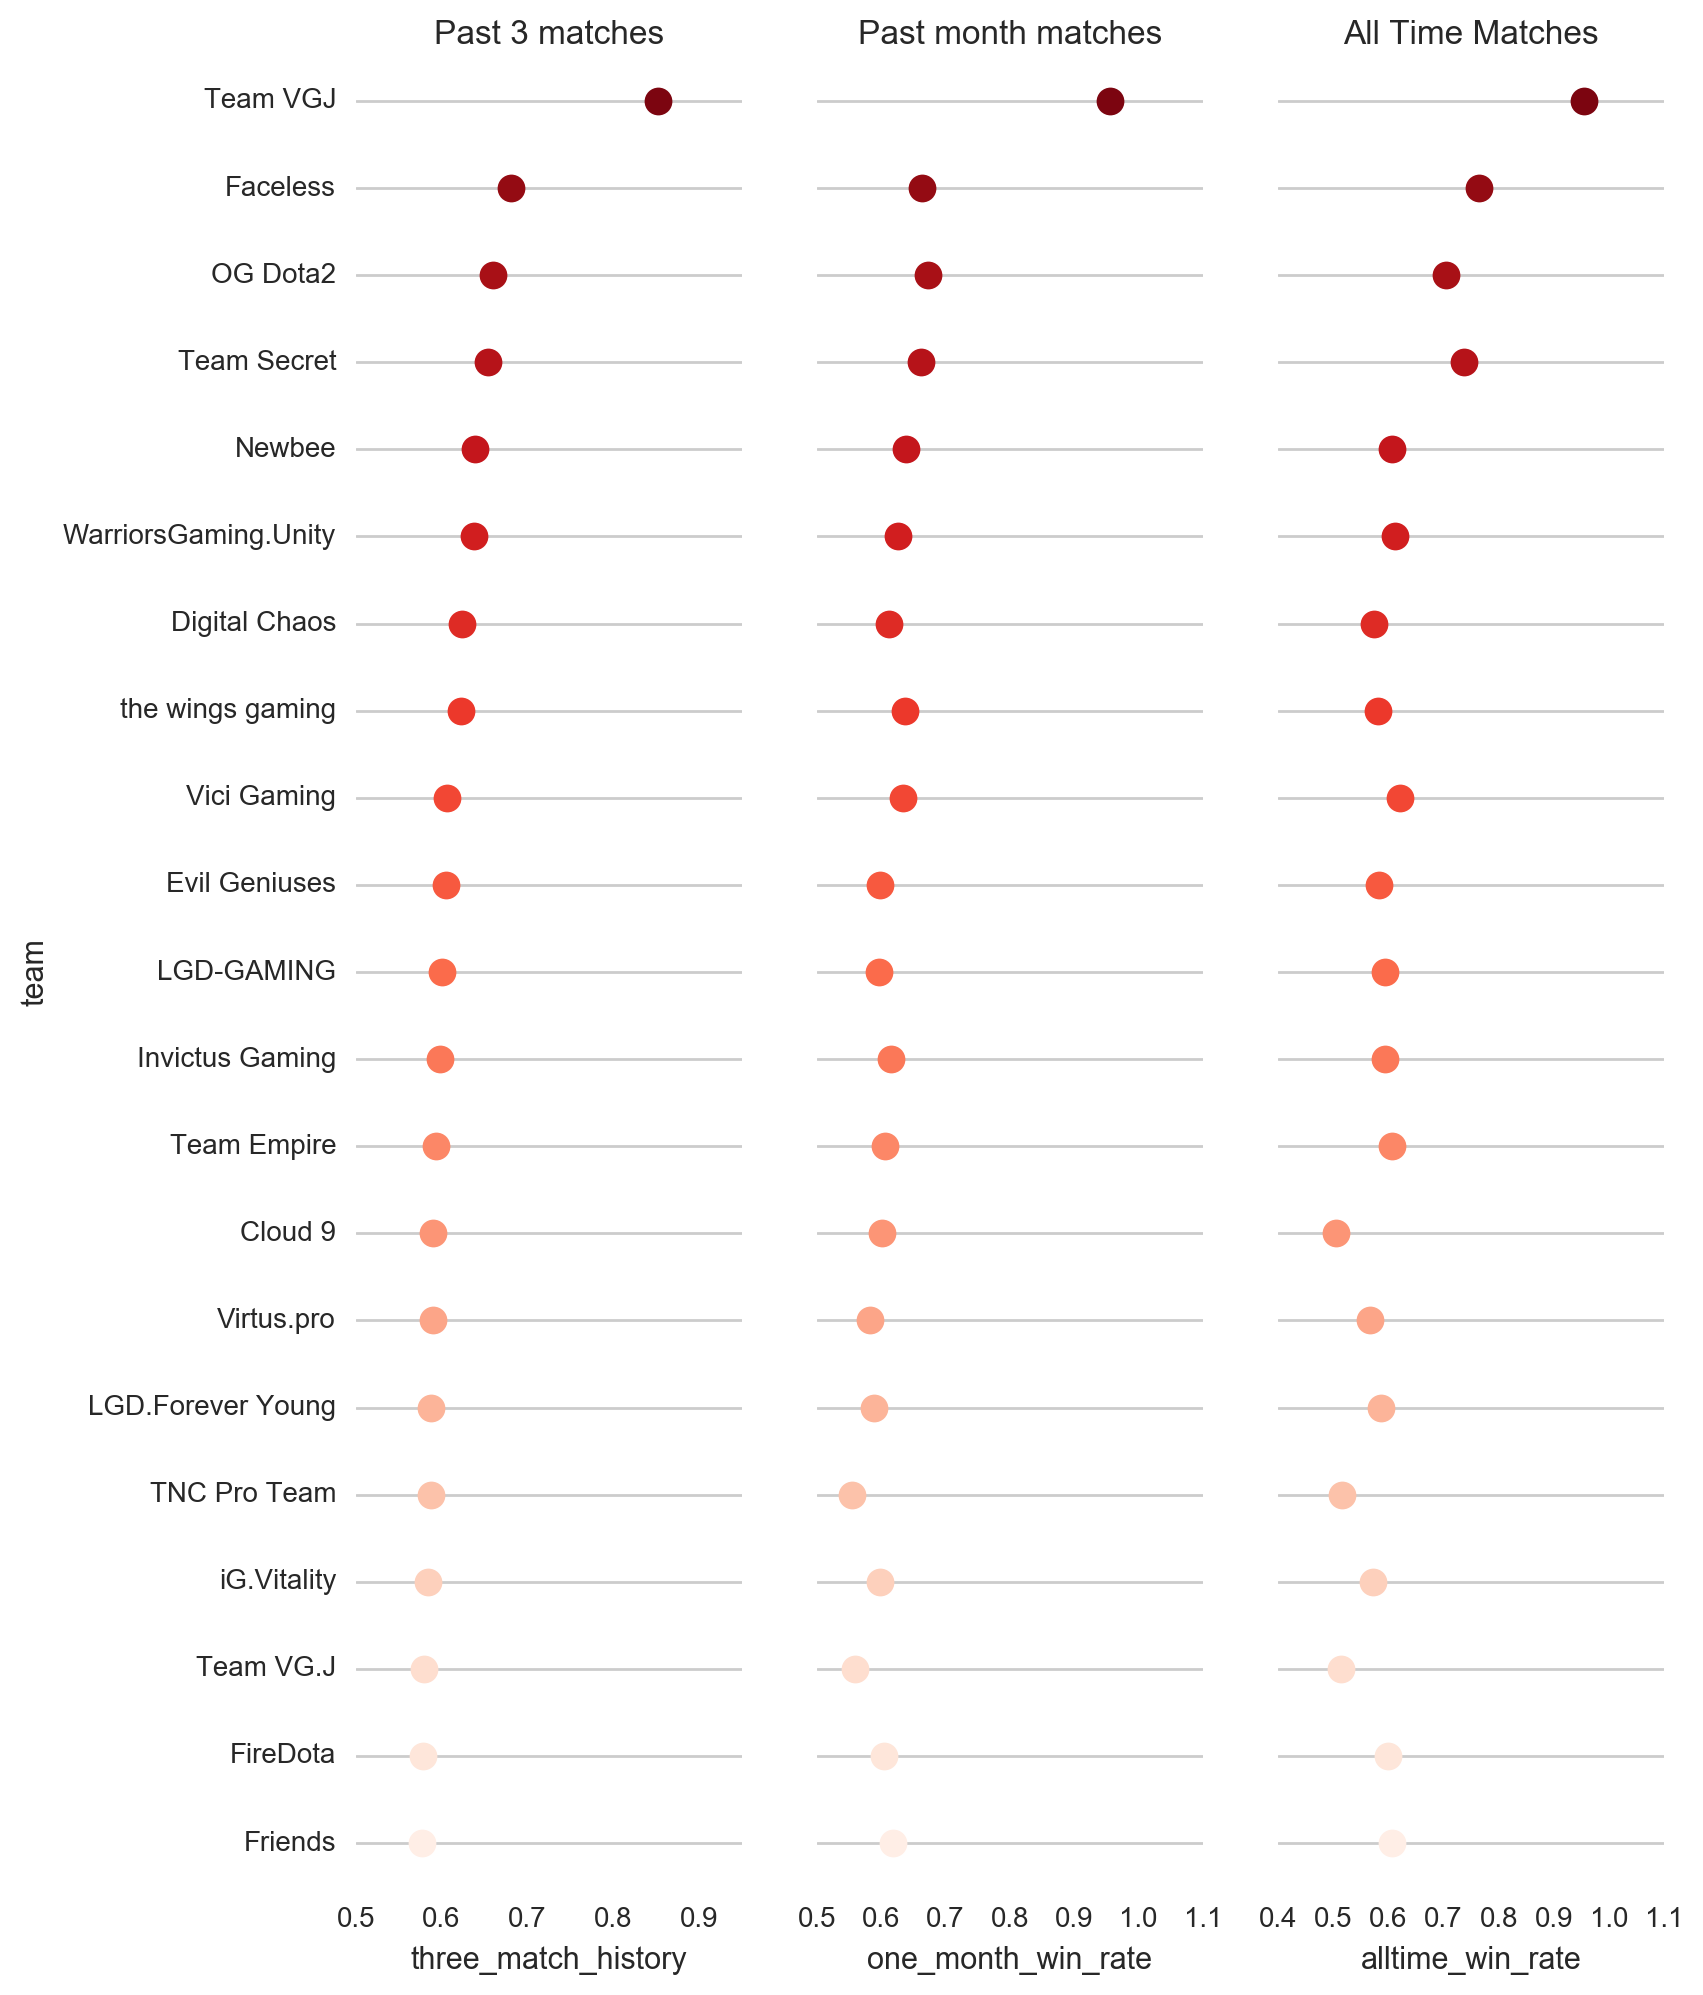

In [59]:
### Creating a dataframe for the Win rates across different time periods
graph = matches.groupby('team')[['three_match_history','one_month_win_rate','alltime_win_rate']].mean().sort('three_match_history',ascending=True).reset_index()

sns.set(style="whitegrid")

# Load the graph


# Make the PairGrid
g = sns.PairGrid(graph.sort_values("three_match_history", ascending=False)[:21],
                 x_vars=graph.columns[1:], y_vars=["team"],
                 size=10, aspect=.25)

# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h",
      palette="Reds_r", edgecolor="gray")


# Use semantically meaningful titles for the columns
titles = ["Past 3 matches", "Past month matches", "All Time Matches"]

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

/Users/tyronewilliams/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


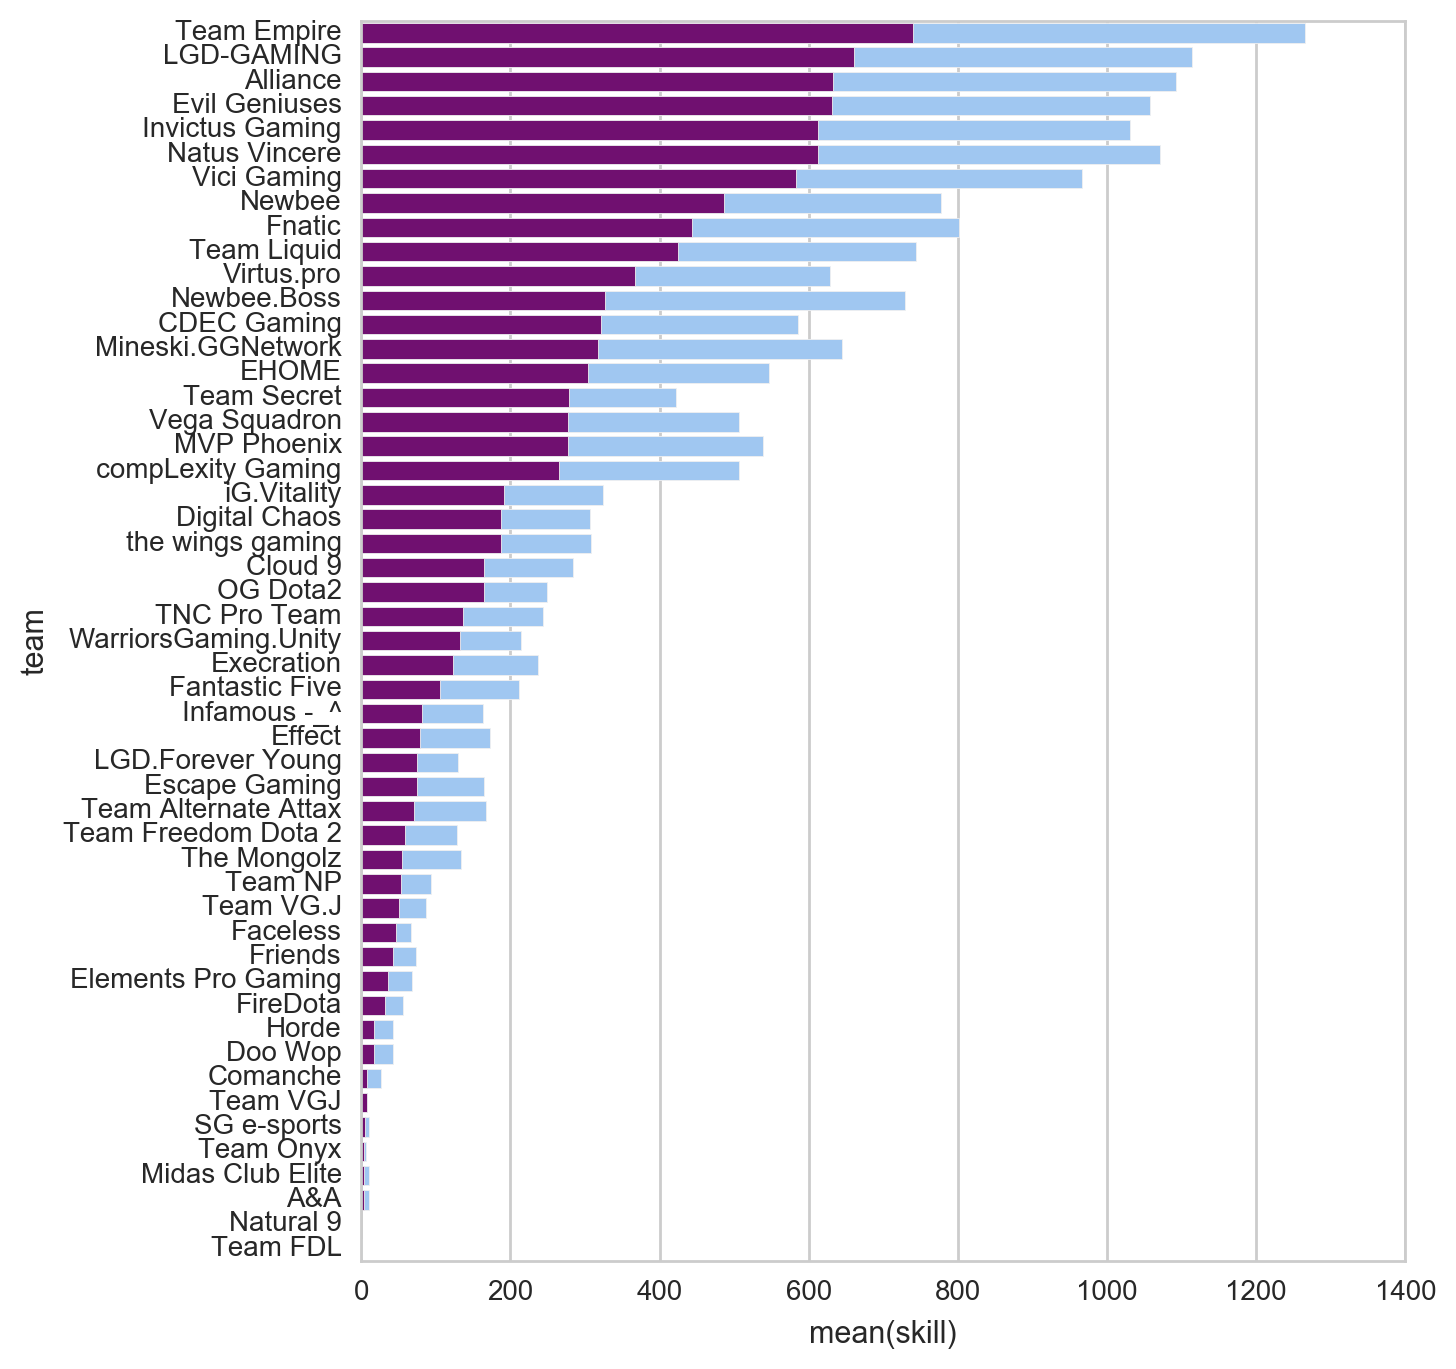

In [62]:
graph = matches.groupby(('team'))[['skill','matches_played']].max().sort('skill', ascending=False).reset_index()

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 8))



# Plot the total matches
sns.set_color_codes("pastel")
sns.barplot(x="matches_played", y="team", data=graph,
            label="total", color="b")

# Plot the matches that were won
sns.set_color_codes("muted")
sns.barplot(x="skill", y="team", data=graph,
            label="matches won", color="purple")


## Anomolies 

In [71]:
graph = matches.groupby('team')[['matches_played','won']].mean().reset_index()
graph.sort_values('won', ascending=False).head(5)

,team,matches_played,won
42,Team VGJ,4.0,0.888889
13,Faceless,33.5,0.676471
40,Team Secret,211.0,0.647754
30,OG Dota2,124.5,0.636000
28,Newbee,389.0,0.629012


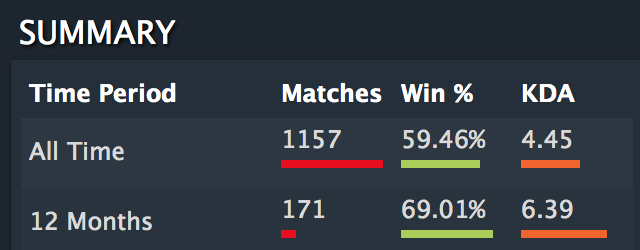

In [79]:
Image(filename='/Users/tyronewilliams/Desktop/Screenshots/Black.png')

Team VGJ and team Faceless have exceeedingly high winrates considering the fact that these teams have played a low amounnt of games. They are clear outliers within the data and I wanted to explore why these teams seem to have high.Above is a screenshot for the player Black^ from team Faceless. The total amount of matches were extremely low but as the data shows, Black^ is an extremely experienced player who has over 1157 games played. 

This makes a lot of sense as some teams would have been newly formed but take experienced players to form them. Unfortunately the data was not added to include the amount of matches each individual player has played as it was not available. Future versions of this model will likely include this information as it more accurately reflects the experience for each team.

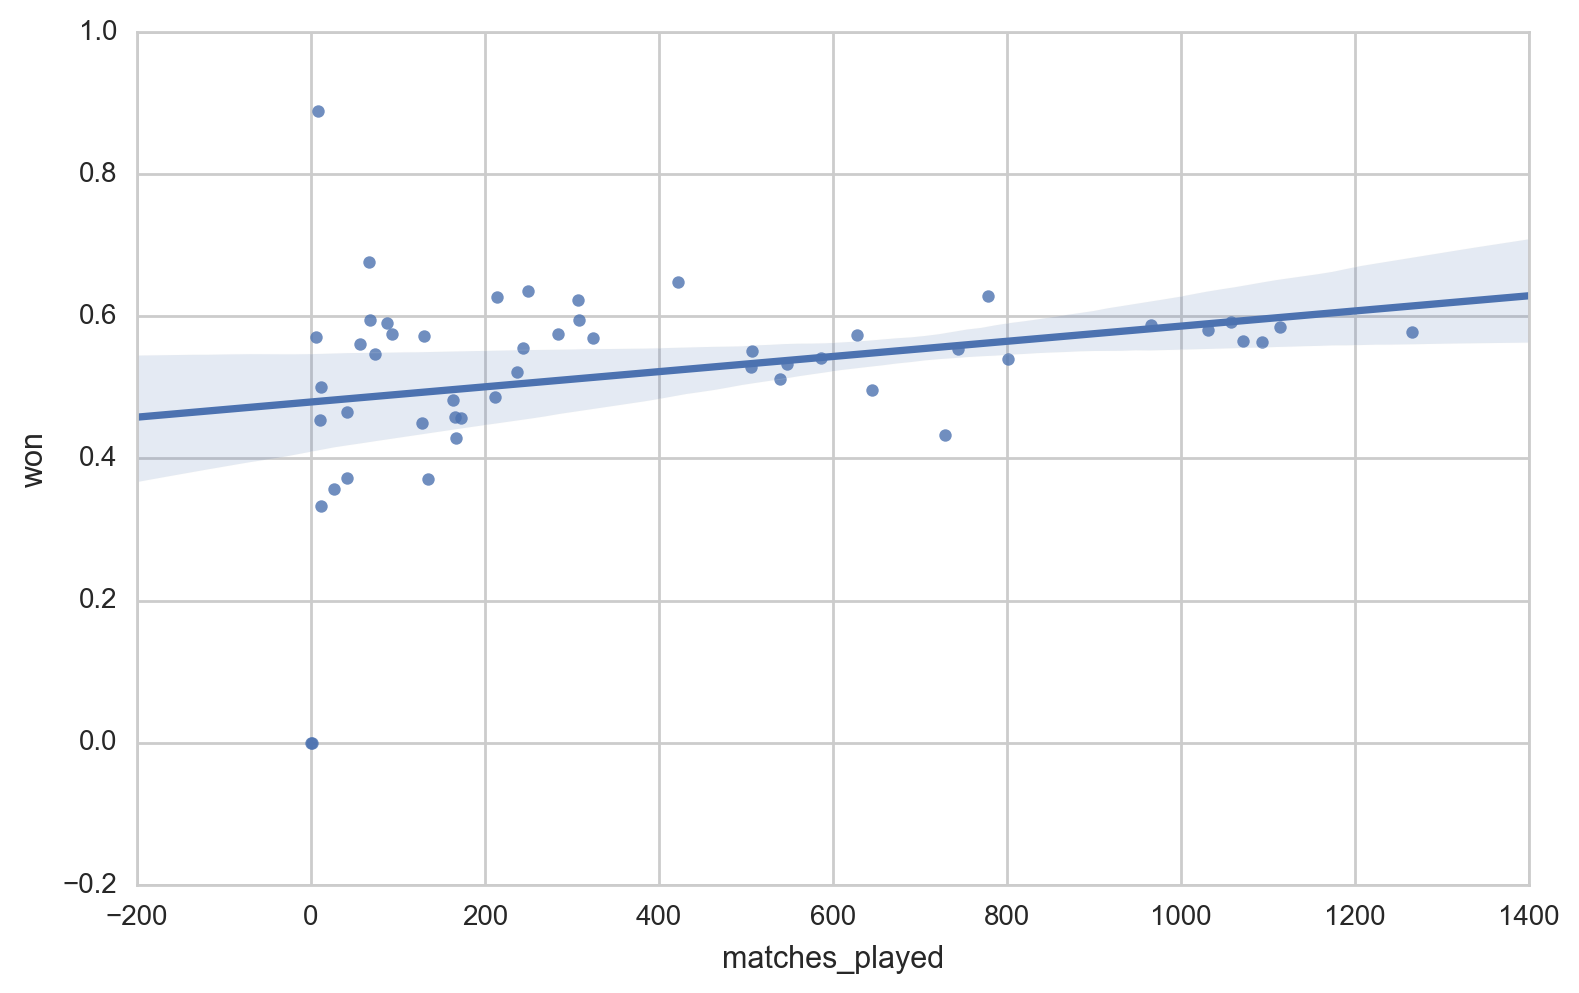

In [65]:
graph = matches.groupby(('team'))[['matches_played']].max().reset_index()
graph_1= matches.groupby(('team'))[['won']].mean().reset_index()
graph = pd.merge(graph,graph_1)
sns.regplot('matches_played','won',data=graph)

# Correlation Matrix

In [82]:
###Correlation matrix on the predictor variables on the target
df_corr = df.corr()
df_corr['won']

duration                        -0.052708
match_id                        -0.023130
won                              1.000000
year                            -0.022355
month                           -0.006311
one_month_win_rate               0.088021
three_month_win_rate             0.102863
six_month_win_rate               0.089413
year_win_rate                    0.077950
alltime_win_rate                 0.075263
one_month_win_rate_opponent     -0.171114
three_month_win_rate_opponent   -0.187970
six_month_win_rate_opponent     -0.186874
year_win_rate_opponent          -0.182888
alltime_win_rate_opponent       -0.182346
last_match_duration_opponent    -0.052356
three_match_duration_opponent   -0.043020
five_match_duration_opponent    -0.047753
ten_match_duration_opponent     -0.045987
all_match_duration_opponent     -0.044935
last_match_history               0.100577
three_match_history              0.095663
five_match_history               0.098000
last_match_history_opponent     -0

# Correlation Heatmap Matrix

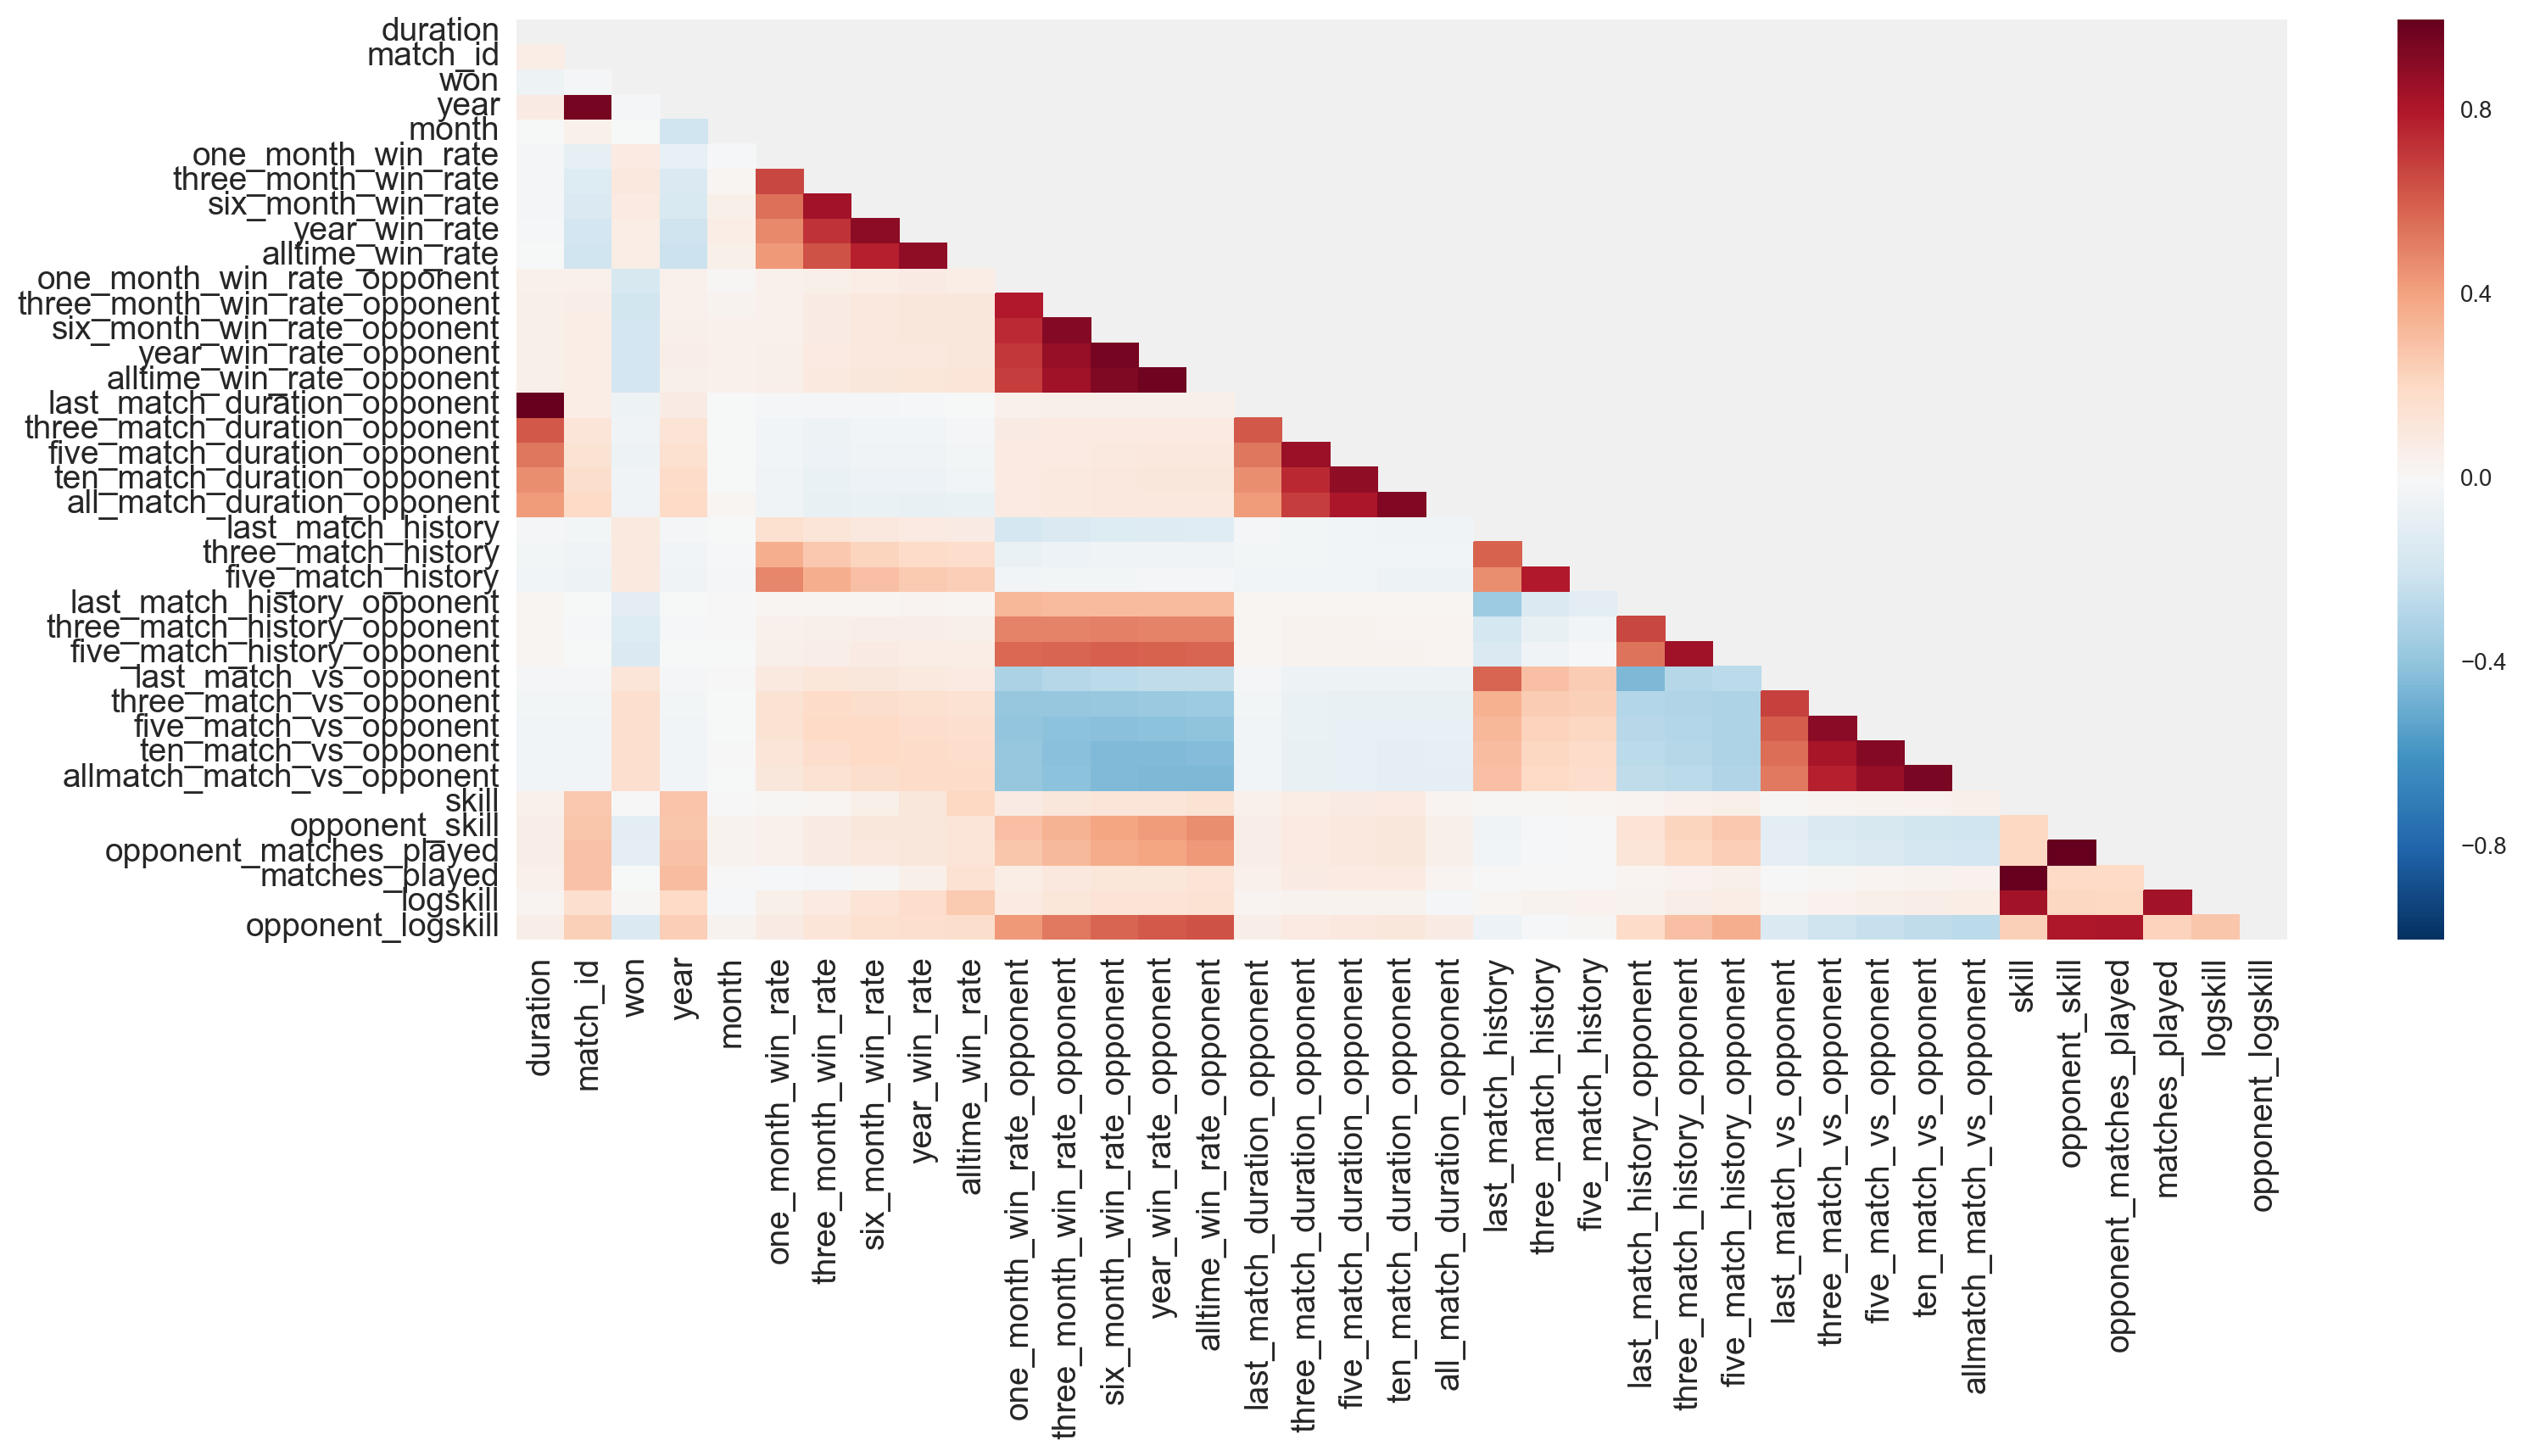

In [83]:
# Set the default matplotlib figure size to 7x7:
plt.rcParams['figure.figsize']=(15,7)

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(df_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(df_corr, mask=mask)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

In [123]:
###creating a forumla to use for patsy

leave_out = ['match_date','league','match_id']
categorical = ['year','month','team','opponent']
continuous = [x for x in df.columns if not x in leave_out+categorical+['won']]
formula = 'won ~ '+'C('+') + C('.join(categorical)+') + '+' + '.join(continuous) + ' -1'



In [124]:
### Creating a matrices from my dependant variables and targets
y, X = patsy.dmatrices(formula_like=formula, data=df, return_type='dataframe')
y = y.values.ravel()

In [125]:
### Splitting my data into testing and training sets. Splitting them 70% train, 30% test
ss = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

## Random Forest

In [126]:
###Checking the shape of the matrices
print X_train.shape, y_train.shape

(12810, 354) (12810,)


In [127]:
### Using gridsearch to find the optimal paramters first. Once GridSearch has chosen the best estimator
### more n_estimators can be added to find a better fit.

rf_params = {
    'max_depth':[None,2,3,4,5],
    'max_features':['log2','sqrt'],
    'min_samples_split':[2,8,32,128,256,512]
}

rfc_gs = GridSearchCV(RandomForestClassifier(n_estimators=300), rf_params, cv=5, verbose=1, n_jobs=3)
rfc_gs.fit(X_train.values, y_train)



Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  2.5min
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  6.0min
[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed:  8.8min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=3,
       param_grid={'max_features': ['log2', 'sqrt'], 'min_samples_split': [2, 8, 32, 128, 256, 512], 'max_depth': [None, 2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [128]:
rfc_gs.best_params_

{'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 32}

In [129]:
###Update the best parameters to include more estimators
best_params = rfc_gs.best_params_
best_params.update({'n_estimators':3000, 'verbose':True})
print best_params

{'max_features': 'sqrt', 'min_samples_split': 32, 'n_estimators': 3000, 'max_depth': None, 'verbose': True}


In [130]:
rfc = RandomForestClassifier(**best_params)
rfc.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    5.4s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:   13.0s
[Parallel(n_jobs=1)]: Done 799 tasks       | elapsed:   24.9s
[Parallel(n_jobs=1)]: Done 1249 tasks       | elapsed:   39.7s
[Parallel(n_jobs=1)]: Done 1799 tasks       | elapsed:   57.0s
[Parallel(n_jobs=1)]: Done 2449 tasks       | elapsed:  1.3min
[Parallel(n_jobs=1)]: Done 3000 out of 3000 | elapsed:  1.6min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=32,
            min_weight_fraction_leaf=0.0, n_estimators=3000, n_jobs=1,
            oob_score=False, random_state=None, verbose=True,
            warm_start=False)

In [131]:
print best_params
print np.mean(y_test), np.mean(y_train)

{'max_features': 'sqrt', 'min_samples_split': 32, 'n_estimators': 3000, 'max_depth': None, 'verbose': True}
0.559270998415 0.556206088993


In [132]:
rfc_gs.best_estimator_.score(X_test, y_test)

0.61442155309033275

In [133]:
rfc.score(X_test, y_test)

[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 799 tasks       | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done 1249 tasks       | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done 1799 tasks       | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 2449 tasks       | elapsed:    4.6s
[Parallel(n_jobs=1)]: Done 3000 out of 3000 | elapsed:    5.5s finished


0.61426307448494455

In [134]:
print np.mean(y_test), np.mean(y_train)

0.559270998415 0.556206088993


In [135]:
y_predicted = rfc.predict_proba(X_test)[:, 1]

[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 799 tasks       | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 1249 tasks       | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done 1799 tasks       | elapsed:    3.1s
[Parallel(n_jobs=1)]: Done 2449 tasks       | elapsed:    4.1s
[Parallel(n_jobs=1)]: Done 3000 out of 3000 | elapsed:    5.1s finished


In [136]:
features = rfc.feature_importances_
columns = X_test.columns

feature_df = pd.DataFrame(features,index=columns, columns=['strength'])
feature_df.index.names =['Component']

    
feature_df = feature_df.reset_index()

# Interpreting the results

In [139]:
def plot_roc(true_y, predicted_y):

    # Get out the predicted probabilities for the X observation matrix
    # y_pp = knn_gs.predict_proba(Xn)

    # roc_curve returns the false positive rate and true positive rates as the threshold changes
    # takes in the y and the predicted probabilities of the positive class from your model.
    fpr, tpr, _ = roc_curve(true_y, predicted_y)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=[5,5])
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('Receiver operating characteristic curve', fontsize=20)
    plt.legend(loc="lower right")
    plt.show()

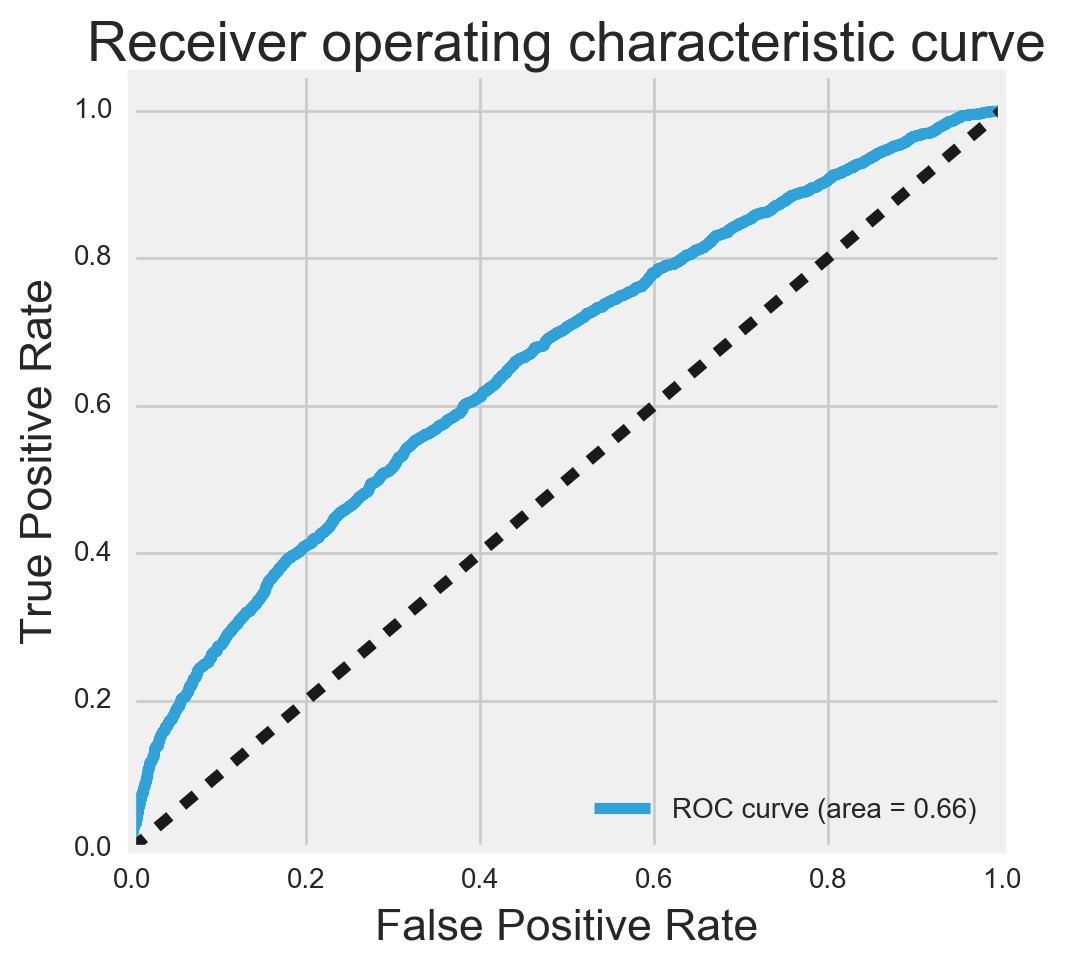

In [140]:
plot_roc(y_test, y_predicted)

In [141]:
y_hat = rfc.predict(X_test)
print classification_report(y_test, y_hat)

[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 799 tasks       | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 1249 tasks       | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 1799 tasks       | elapsed:    3.1s
[Parallel(n_jobs=1)]: Done 2449 tasks       | elapsed:    4.2s


             precision    recall  f1-score   support

        0.0       0.58      0.47      0.52      2781
        1.0       0.63      0.73      0.68      3529

avg / total       0.61      0.61      0.61      6310



[Parallel(n_jobs=1)]: Done 3000 out of 3000 | elapsed:    5.1s finished


## ROC Curve

The model is predicting teams loss with a 58% accuracy and is predicting a team win with an accuracy of about 63%. The area under the ROC curve is 0.66 which, again, seems poor but any result above the baseline will result in an economic profit.

# Application

### Predicting outcome given two teams

In [145]:
df_pred = df[['year','month','team','opponent','won']]
df_pred.head()

,year,month,team,opponent,won
0,2017,1,Evil Geniuses,OG Dota2,1
1,2017,1,Evil Geniuses,OG Dota2,1
2,2017,1,Evil Geniuses,OG Dota2,1
3,2017,1,Evil Geniuses,OG Dota2,0
4,2017,1,Evil Geniuses,OG Dota2,1


In [146]:
df_pred['match_date'] = df_pred.year + (df_pred.month-0.5)/12.
df_pred['match_date'] = df_pred.match_date - 2000.
df_pred.head()

/Users/tyronewilliams/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/tyronewilliams/anaconda/envs/dsi/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,year,month,team,opponent,won,match_date
0,2017,1,Evil Geniuses,OG Dota2,1,17.041667
1,2017,1,Evil Geniuses,OG Dota2,1,17.041667
2,2017,1,Evil Geniuses,OG Dota2,1,17.041667
3,2017,1,Evil Geniuses,OG Dota2,0,17.041667
4,2017,1,Evil Geniuses,OG Dota2,1,17.041667


In [147]:
df_pred = df_pred[['team','opponent','match_date', 'won']]
f = 'won ~ C(team) + C(opponent) + match_date -1'
y, X = patsy.dmatrices(formula_like=f, return_type='dataframe', data=df_pred)
y = y.values.ravel()

In [148]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3)

In [149]:
rfc_team = RandomForestClassifier(n_estimators=5000, max_depth=None, verbose=1, n_jobs=-1)
rfc_team.fit(X_tr, y_tr)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:   59.0s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  4.0min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)

In [150]:
print np.mean(y_te)
rfc_team.score(X_te, y_te)

0.550557880056


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed:    6.0s
[Parallel(n_jobs=4)]: Done 3192 tasks      | elapsed:    7.4s
[Parallel(n_jobs=4)]: Done 4042 tasks      | elapsed:    9.0s
[Parallel(n_jobs=4)]: Done 4992 tasks      | elapsed:   10.6s
[Parallel(n_jobs=4)]: Done 5000 out of 5000 | elapsed:   10.6s finished


0.59902370990237097

In [151]:
def team_opp_predict_proba(model, columns, team, opponent, dates=[17.2]):
    predmat = np.zeros((len(dates), len(columns)))
    predmat[:, -1] = dates
    team_index = [i for i,c in enumerate(columns) if 'C(team)' in c and team in c][0]
    opp_index = [i for i,c in enumerate(columns) if 'C(opponent)' in c and opponent in c][0]
    predmat[:, team_index] = 1.
    predmat[:, opp_index] = 1.
    pp = model.predict_proba(predmat)
    return pp[:, 1]

In [152]:
probs = team_opp_predict_proba(rfc_team, X.columns, 'Evil Geniuses', 'Team Secret', dates=np.linspace(12., 17., 100))

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 2442 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 3192 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 4042 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 4992 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 5000 out of 5000 | elapsed:    2.1s finished


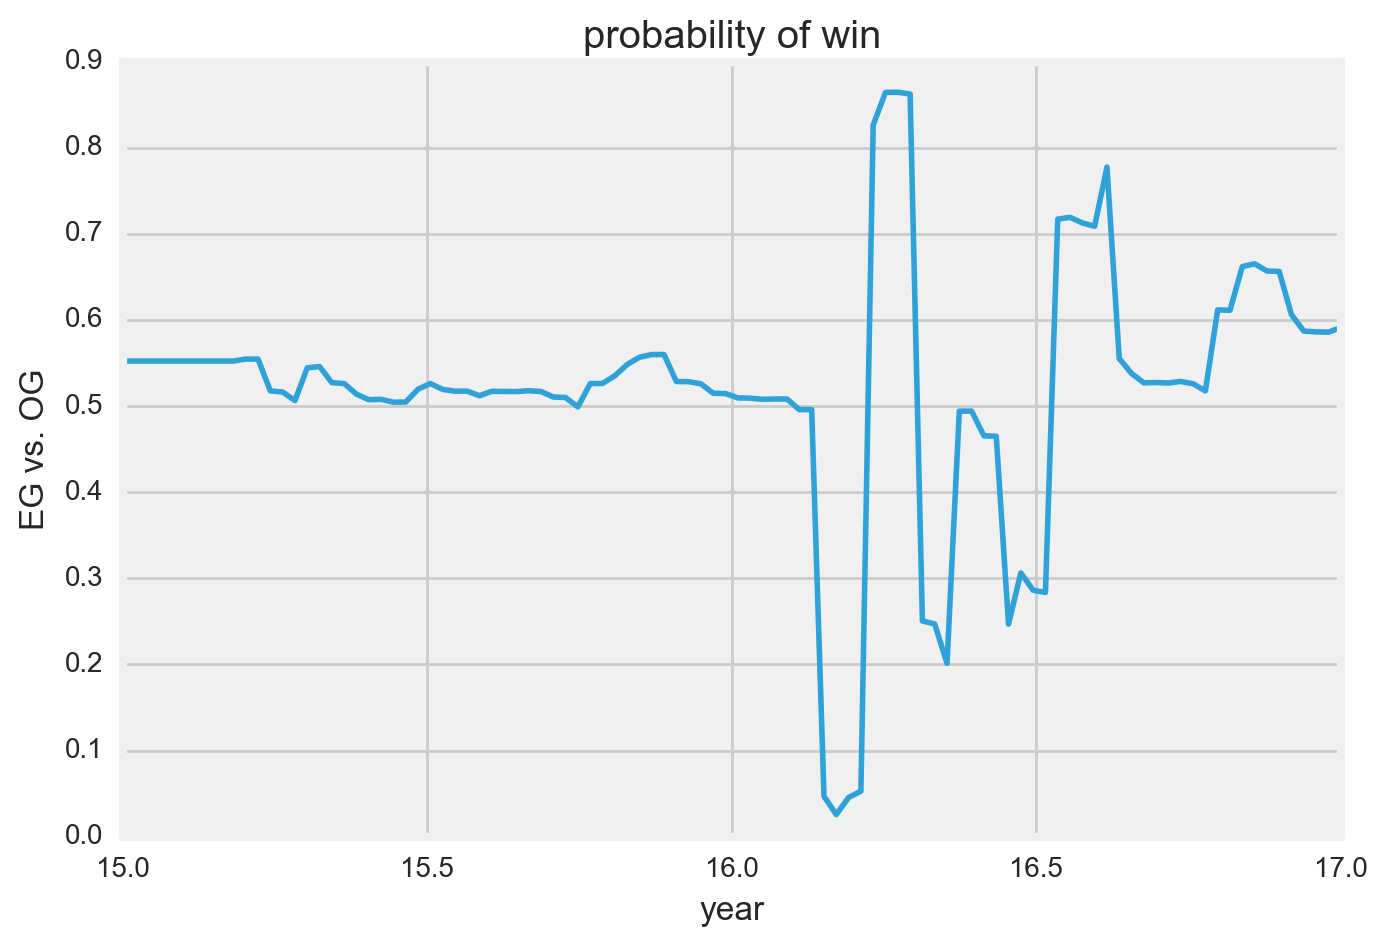

In [153]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(np.linspace(15, 17., 100), probs, lw=2.)
ax.set_xlabel('year')
ax.set_ylabel('EG vs. OG')
ax.set_title('probability of win')
plt.show()